In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!pip install xgboost

##Load the preprocessed Dataset

In [2]:
import numpy as np       
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import pickle
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split

path = "/content/drive/MyDrive/Bachelorarbeit/PreProcessed_NYC_GreenTaxi.csv"
df = pd.read_csv(path)

In [3]:
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')
df["pickup_weekday"] = df["pickup_datetime"].dt.weekday
df["dropoff_weekday"] = df["dropoff_datetime"].dt.weekday
# Get latitude and longitude differences
df["latitude_difference"] = df["dropoff_latitude"] - df["pickup_latitude"]
df["longitude_difference"] = df["dropoff_longitude"] - df["pickup_longitude"]

## Train and Save the XGBoost Model
#### The following features were used to train the model and predict trip duration in minutes: *'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance', 'pickup_weekday', 'pickup_hour', 'pickup_minute'.*


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[0]	eval-rmse:1.99236	train-rmse:1.99174	eval-RMSLE:0.754979	train-RMSLE:0.754772
[1]	eval-rmse:1.79608	train-rmse:1.79553	eval-RMSLE:0.647679	train-RMSLE:0.647506
[2]	eval-rmse:1.62044	train-rmse:1.61992	eval-RMSLE:0.56072	train-RMSLE:0.560557
[3]	eval-rmse:1.46255	train-rmse:1.46203	eval-RMSLE:0.488758	train-RMSLE:0.488598
[4]	eval-rmse:1.32022	train-rmse:1.31975	eval-RMSLE:0.428225	train-RMSLE:0.428086
[5]	eval-rmse:1.19303	train-rmse:1.19252	eval-RMSLE:0.3771	train-RMSLE:0.376939
[6]	eval-rmse:1.07904	train-rmse:1.07844	eval-RMSLE:0.333483	train-RMSLE:0.333282
[7]	eval-rmse:0.97621	train-rmse:0.975567	eval-RMSLE:0.295819	train-RMSLE:0.295605
[8]	eval-rmse:0.883881	train-rmse:0.883129	eval-RMSLE:0.263261	train-RMSLE:0.263006
[9]	eval-rmse:0.801197	train-rmse:0.800272	eval-RMSLE:0.235031	train-RMSLE:0.234715
[10]	eval-rmse:0.727995	train-rmse:0.726879	eval-RMSLE:0.21065	train-RMSLE:0.210269
[11]	eval-rmse:0.662035	train-rmse:0.66074	eval-RMSLE:0.189293	train-RMSLE:0.188847
[12]	eval-

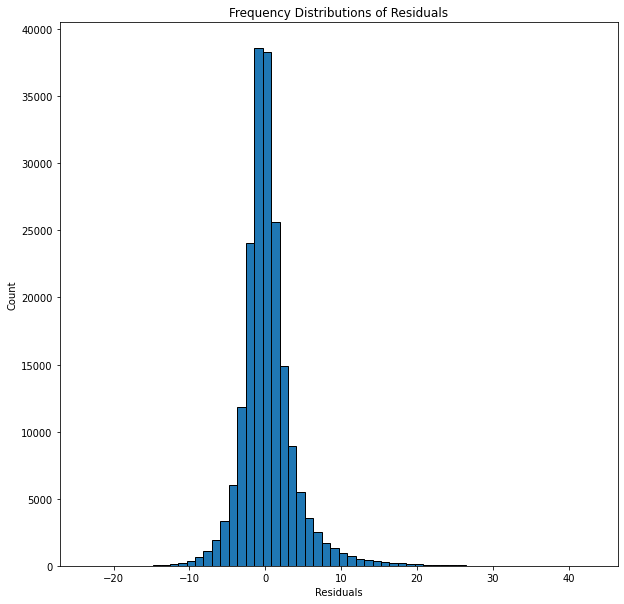

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,pickup_weekday,pickup_hour,pickup_minute
count,974573.000000,974573.000000,974573.000000,974573.000000,974573.000000,974573.000000,974573.000000,974573.000000
mean,-73.938437,40.741255,-73.937213,40.738818,3.261228,3.291791,13.413484,29.599086
std,0.042233,0.051365,0.050453,0.050561,2.556901,1.932511,6.835839,17.277589
min,-74.029984,40.630013,-74.029984,40.630005,1.000000,0.000000,0.000000,0.000000
25%,-73.963348,40.693432,-73.973763,40.694492,1.540000,2.000000,9.000000,15.000000
50%,-73.949013,40.737549,-73.948822,40.741756,2.400000,3.000000,15.000000,30.000000
75%,-73.920174,40.790810,-73.913116,40.774288,4.000000,5.000000,19.000000,45.000000
max,-73.750046,40.849998,-73.750000,40.849998,29.500000,6.000000,23.000000,59.000000


In [5]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.graphics.api import abline_plot
import seaborn as sns


def rmsle(y_true, y_pred):
    labels = y_pred.get_label()
    diffs = np.log(y_true + 1) - np.log(labels + 1)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('RMSLE', np.sqrt(avg))

def XGBmodel(X, y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
  dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
  dtest = xgb.DMatrix(X_test, np.log(y_test+1))

  params = {
    'min_child_weight': 1, 
    'learning_rate': 0.1, 
    'colsample_bytree': 0.7, 
    'max_depth': 14,
    'subsample': 0.9,
    'n_estimators': 500,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'feval': 'rmsle',
    }
  watchlist = [(dtest, 'eval'), (dtrain, 'train')]
  # Number of training rounds
  nrounds = 500
  # Train model
  gbm = xgb.train(params, dtrain, num_boost_round = nrounds, evals = watchlist, feval=rmsle,  verbose_eval = True)

  # Test predictions
  y_pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1
  # Mean absolute error to get a basic estimate of the error
  mae = (abs(y_pred - y_test)).mean()
  print('Mean Absolute Error:', mae)
  print(max(y_pred))

  # plotting residuals
  residuals = y_test - y_pred
  max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
  print("Max Error:", "{:,.0f}".format(max_error))
  
  #Predicted vs Residuals
  #plt.figure(figsize=(10,10))
  #plt.scatter(y_pred, residuals, edgecolor='black')
  #plt.vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
  #plt.grid(True)
  #plt.xlabel('Predicted')
  #plt.ylabel('Residuals')
  #plt.title('Predicted values vs Residuals')
  #plt.legend()
  #plt.show()

  #Frequency Distributions of Residuals
  plt.figure(figsize=(10,10))
  plt.hist(residuals, bins=60, edgecolor='black')
  plt.xlabel('Residuals')
  plt.ylabel('Count')
  plt.title('Frequency Distributions of Residuals')
  plt.show()

  return gbm

X = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance', 'pickup_weekday', 'pickup_hour', 'pickup_minute']]
y = df['trip_duration_min']
model = XGBmodel(X, y)
filename = "nyc_xgboost_model.sav"
pickle.dump(model, open(filename, 'wb'))
X.describe()



## Load the saved model

In [6]:
filename = "nyc_xgboost_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

##Objective Function
##### The following code was borrowed from these repositories and modified to apply Genetic Algorithms to the problem. 
1. https://github.com/khanhnamle1994/trip-optimizer/blob/master/Bio-Inspired-Algorithms/genetic_evo_main.py#L1
2. https://github.com/guofei9987/scikit-opt/blob/master/examples/demo_ga_udf_tsp.py


In [32]:
from scipy import spatial
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import pprint

geolocator = Nominatim(user_agent="aco-application")

filename = "nyc_xgboost_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))

def time_cost_between_points(loc1, loc2, pickup_weekday, pickup_hour, pickup_minute):
    """
    Calculate the time (in minutes) between two points
    using the trained XGB model
    """

    model_data = {
                  'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'trip_distance': trip_distance_cost(loc1, loc2),
                  'pickup_weekday': pickup_weekday,
                  'pickup_hour': pickup_hour,
                  'pickup_minute': pickup_minute,
                  }

    print(model_data)
    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    #print(pred[0])
    return pred[0]


def trip_distance_cost(loc1, loc2):
    """
    Calculate the manhattan distance between two points using
    polar coordinates in taxicab geometry https://en.wikipedia.org/wiki/Taxicab_geometry
    """
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))


def total_cost_from_path(path):
    """
    Calculate the time (in minutes) to travel a path
    using the trained XGB model
    """
    total_cost = 0
    for i in range(1, len(path)):
        j = i - 1
        #total_cost += np.array(cost_matrix[path[j]][path[i]])[:,0]
        total_cost += cost_matrix[path[j]][path[i]]
    # Find time it takes to go back to original location
    total_cost += cost_matrix[path[-1]][path[0]]
    #total_cost = np.array(total_cost) ##modified here
    return total_cost
    #print('total cost', total_cost)



locations = []
points = []

for index, row in df.iloc[:14].iterrows(): #take the first 50 rows within the dataset as input coordinates

        locations.append({
              'index': index,
              'x': row['pickup_longitude'],
              'y': row['pickup_latitude']
          })
        points.append((row['pickup_longitude'], row['pickup_latitude']))

# Build complete cost matrix based on time between points
cost_matrix = []
rank = len(locations)
for i in range(rank):
    row = []
    for j in range(rank):
        row.append(time_cost_between_points(locations[i], locations[j],  3, 15, 40))
    cost_matrix.append(row)
#print(cost_matrix)


{'pickup_longitude': -73.93058013916014, 'pickup_latitude': 40.695178985595696, 'dropoff_longitude': -73.93058013916014, 'dropoff_latitude': 40.695178985595696, 'trip_distance': 0.0, 'pickup_weekday': 3, 'pickup_hour': 15, 'pickup_minute': 40}
{'pickup_longitude': -73.93058013916014, 'pickup_latitude': 40.695178985595696, 'dropoff_longitude': -73.94692993164062, 'dropoff_latitude': 40.79255294799805, 'trip_distance': 7.857549827584941, 'pickup_weekday': 3, 'pickup_hour': 15, 'pickup_minute': 40}
{'pickup_longitude': -73.93058013916014, 'pickup_latitude': 40.695178985595696, 'dropoff_longitude': -73.94453430175781, 'dropoff_latitude': 40.82395553588867, 'trip_distance': 9.861736359482991, 'pickup_weekday': 3, 'pickup_hour': 15, 'pickup_minute': 40}
{'pickup_longitude': -73.93058013916014, 'pickup_latitude': 40.695178985595696, 'dropoff_longitude': -73.95220947265625, 'dropoff_latitude': 40.82387161254883, 'trip_distance': 10.386240725405811, 'pickup_weekday': 3, 'pickup_hour': 15, 'pick

In [ ]:
print ('cost_matrix:', cost_matrix[1][0])

cost_matrix: 40.528732


##Brute Force O(n!)

In [ ]:
from sys import maxsize
import time


v = 14
def travelling_salesman_function(graph, s):
    vertex = [] #points or locations
    for i in range(v):
        if i != s:
            vertex.append(i)

    min_path = maxsize
    while True:
        current_cost = 0
        k = s
        for i in range(len(vertex)):
            current_cost += graph[k][vertex[i]]
            k = vertex[i]
        current_cost += graph[k][s]
        min_path = min(min_path, current_cost)

        if not next_perm(vertex):
            break
    return min_path 

def next_perm(l):
    n = len(l)
    i = n-2

    while i >= 0 and l[i] > l[i+1]:
        i -= 1
    
    if i == -1:
        return False

    j = i+1
    while j < n and l[j] > l[i]:
        j += 1

    j -= 1

    l[i], l[j] = l[j], l[i]
    left = i+1
    right = n-1

    while left < right:
        l[left], l[right] = l[right], l[left]
        left += 1
        right -= 1
    return True

graph = cost_matrix
s = 0

start_time = time.time()
res = travelling_salesman_function(graph,s)
print("Execution time: %s seconds " % (time.time() - start_time))

print('Trip Duration:', res)